In [1]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fileName1 = "/eos/user/k/kmonagha/dijet_events_data/SM_events/dijet_events_full_2000_2447.root"
treeName1 = "dijets"

fileName2 = "/eos/user/k/kmonagha/dijet_events_data/ADD_events/ADDbsm_LambdaT10000_full_2100_2400.root"
treeName2 = "dijets"

fileName3 = "/eos/user/k/kmonagha/dijet_events_data/ADD_events/ADDbsm_LambdaT8000_full_2100_2300.root"
treeName3 = "dijets"

fileName4 = "/eos/user/k/kmonagha/dijet_events_data/ADD_events/ADDbsm_LambdaT15000_full_3000_3097.root"
treeName4 = "dijets"

d_sm = ROOT.RDataFrame(treeName1, fileName1)
d_add_10 = ROOT.RDataFrame(treeName2, fileName2)
d_add_8 = ROOT.RDataFrame(treeName3, fileName3)
d_add_15 = ROOT.RDataFrame(treeName4,fileName4)

ROOT.gInterpreter.Declare('#include "Math/VectorUtil.h"')

def root_hist_to_numpy(h, normalize=False):
    edges = np.array([h.GetBinLowEdge(i+1) for i in range(h.GetNbinsX()+1)])
    values = np.array([h.GetBinContent(i+1) for i in range(h.GetNbinsX())])
    errors = np.array([h.GetBinError(i+1) for i in range(h.GetNbinsX())])

    if normalize and values.sum() > 0:
        values_norm = values / values.sum()
        errors_norm = errors / values.sum()
        return edges, values_norm, values, errors, errors_norm
    else:
        return edges, values, values, errors, errors

def compute_significance(sm_vals, add_vals, sm_errors, syst_frac, label):
    """
    Compute weighted χ² significance between SM and ADD histograms.
    alpha = 0 -> no weighting (standard χ²)
    alpha = 1 -> strong suppression of high-stat bins
    """
    if len(sm_vals) != len(add_vals):
        raise ValueError("Histogram bins do not match in size.")
       
    chi2 = 0
    ndf = 0
    EPSILON = 1e-3

    for sm, add, err in zip(sm_vals, add_vals, sm_errors):
        if sm <= 0:
            continue  # skip empty bins
       
        add = max(add, EPSILON)
        sigma_stat = np.sqrt(sm)
        sigma_syst = syst_frac * sm
        sigma_tot = max(np.sqrt(sigma_stat**2 + sigma_syst**2), EPSILON)
       
        chi2 += ((add - sm) ** 2) / sigma_tot**2
        ndf += 1


    significance = np.sqrt(chi2) if chi2 > 0 else 0
    print(f"[{label}] χ²: {chi2:.2f}, NDF: {ndf}, Significance: {significance:.2f}σ")
    return chi2, ndf, significance

def variable_binning_dual(observed_sm, observed_add, errors_sm, bin_edges, min_expected=10):
    bins_to_combine = []
    current_sum_sm = 0
    current_sum_add = 0

    for i in range(len(observed_sm)):
        current_sum_sm += observed_sm[i]
        current_sum_add += observed_add[i]

        if current_sum_sm >= min_expected and current_sum_add >= min_expected:
            bins_to_combine.append(i)
            current_sum_sm = 0
            current_sum_add = 0

    if bins_to_combine:
        last_bin_end = bins_to_combine[-1]
        if last_bin_end < len(observed_sm) - 1:
            # Get remainder bins
            remaining_sm = np.sum(observed_sm[last_bin_end + 1:])
            remaining_add = np.sum(observed_add[last_bin_end + 1:])
            if remaining_sm >= min_expected and remaining_add >= min_expected:
                bins_to_combine.append(len(observed_sm) - 1)
        else:
            # Merge with previous
            bins_to_combine[-1] = len(observed_sm) - 1

    new_obs_sm = []
    new_obs_add = []
    new_err_sq = []
    new_edges = [bin_edges[0]]
    start_idx = 0
    for idx in bins_to_combine:
        new_obs_sm.append(np.sum(observed_sm[start_idx:idx + 1]))
        new_obs_add.append(np.sum(observed_add[start_idx:idx + 1]))
        new_err_sq.append(np.sum(errors_sm[start_idx:idx + 1] ** 2))
        new_edges.append(bin_edges[idx + 1])
        start_idx = idx + 1

    new_err = np.sqrt(new_err_sq)
    return np.array(new_obs_sm), np.array(new_obs_add), new_err, np.array(new_edges), bins_to_combine

def apply_variable_binning(values, bins_to_combine):
    """
    Apply the same binning as from variable_binning_dual() to a new array (e.g., another model's counts).
    """
    new_values = []
    start_idx = 0
    for idx in bins_to_combine:
        new_values.append(np.sum(values[start_idx:idx + 1]))
        start_idx = idx + 1
    return np.array(new_values)

# Define Mjj bins (GeV)
mjj_bins = [(20, 40), (40, 100), (100, 200), (200, 1000)]

LUMI = 30 # fb^-1
sigma_sm =  27110000000 #fb
sigma_add = 27110000000 #fb 51860000000
trigEff = 1/1000
jetReco = 4/5
acceptance = trigEff*jetReco
num_gen_sm = d_sm.Count().GetValue()
num_gen_add10 = d_add_10.Count().GetValue()
num_gen_add8 = d_add_8.Count().GetValue()
num_gen_add15 = d_add_15.Count().GetValue()


# Compute scaling factors for statistical analysis using the predicted N from sigma* lumi, and the N generated
scale_sm = (sigma_sm * LUMI) * acceptance / num_gen_sm
scale_add15 = (sigma_add * LUMI) * acceptance / num_gen_add15
scale_add10 = (sigma_add * LUMI) * acceptance / num_gen_add10
scale_add8 = (sigma_add * LUMI) * acceptance / num_gen_add8

In [2]:
# Define function to classify the process type based on IDs
ROOT.gInterpreter.Declare("""
std::string get_process_type(int id1, int id2) {
    int orig_id1 = id1;
    int orig_id2 = id2;
    id1 = abs(id1);
    id2 = abs(id2);
    bool is_quark1 = id1 >= 1 && id1 <= 6;
    bool is_quark2 = id2 >= 1 && id2 <= 6;
    bool is_gluon1 = (id1 == 21);
    bool is_gluon2 = (id2 == 21);

if (is_gluon1 && is_gluon2)
    return "gg";                     

if (is_quark1 && is_gluon2 || (is_gluon1 && is_quark2))
    return "qg";
                                                    
if (is_quark1 && is_quark2) {
    if ((id1 == id2) && (orig_id1 * orig_id2 < 0))
        return "qqbar";
    if (id1 == id2)
        return "qq";
    return "qqprime";
}
    
return "other";
}
""")

# Define new column for process
d_sm = d_sm.Define("process_type", "get_process_type(id1, id2)")
d_add_15 = d_add_15.Define("process_type", "get_process_type(id1, id2)")
d_add_10 = d_add_10.Define("process_type", "get_process_type(id1, id2)")
d_add_8 = d_add_8.Define("process_type", "get_process_type(id1, id2)")

Here we have a comparison of the Chi dijet in all 4 Mjj bins with the 15, 10, and 8 TeV lambda ADD models compared with SM

[15TeV 20-40 GeV] χ²: 97.32, NDF: 6, Significance: 9.87σ
[10TeV 20-40 GeV] χ²: 72.60, NDF: 6, Significance: 8.52σ
[8TeV 20-40 GeV] χ²: 55.31, NDF: 6, Significance: 7.44σ
[15TeV 40-100 GeV] χ²: 1442.95, NDF: 27, Significance: 37.99σ
[10TeV 40-100 GeV] χ²: 395.92, NDF: 27, Significance: 19.90σ
[8TeV 40-100 GeV] χ²: 257.30, NDF: 27, Significance: 16.04σ
[15TeV 100-200 GeV] χ²: 275.00, NDF: 29, Significance: 16.58σ
[10TeV 100-200 GeV] χ²: 87.69, NDF: 29, Significance: 9.36σ
[8TeV 100-200 GeV] χ²: 65.40, NDF: 29, Significance: 8.09σ
[15TeV 200-1000 GeV] χ²: 2764.58, NDF: 25, Significance: 52.58σ
[10TeV 200-1000 GeV] χ²: 572.00, NDF: 25, Significance: 23.92σ
[8TeV 200-1000 GeV] χ²: 964.22, NDF: 25, Significance: 31.05σ


/tmp/kmonagha/ipykernel_1425298/281066809.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


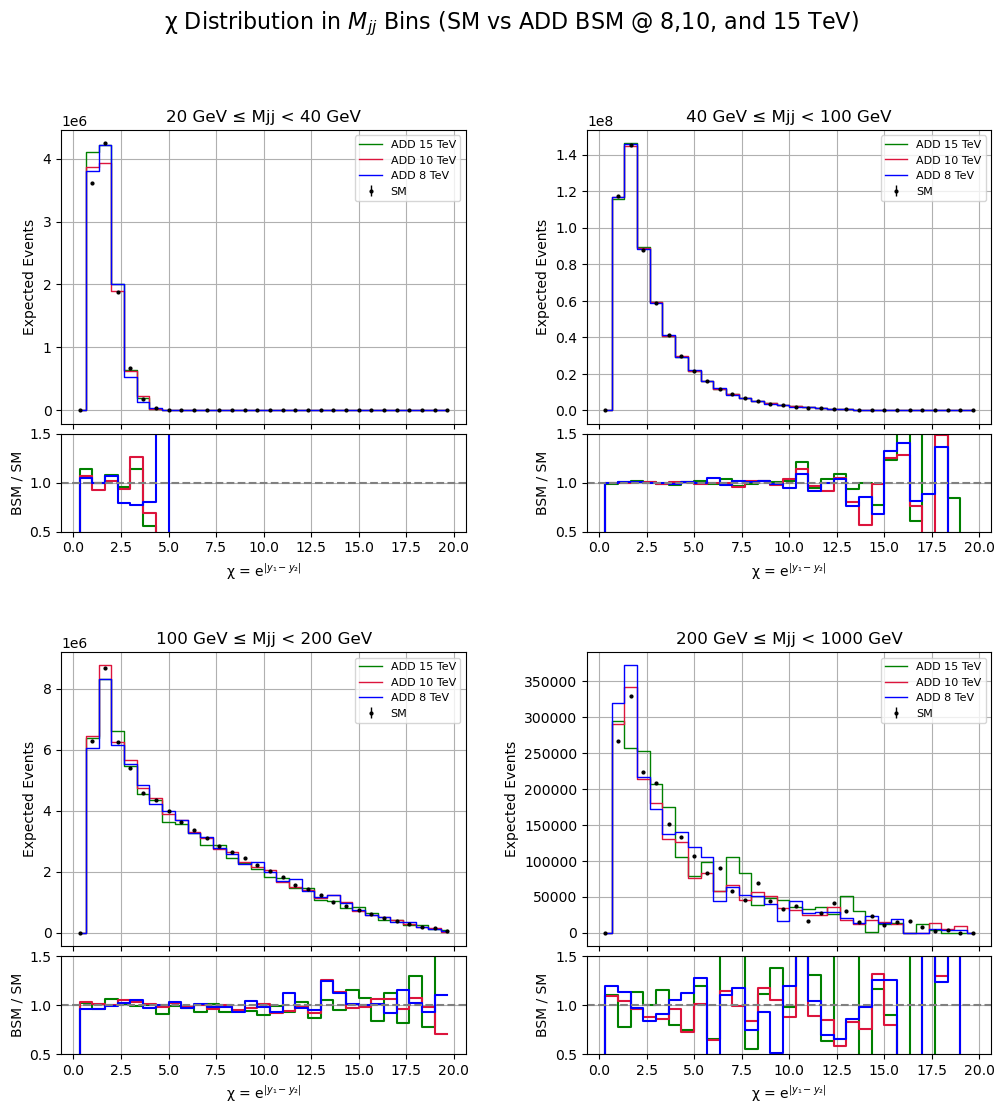

In [ ]:
fig = plt.figure(figsize=(12, 12))
outer_gs = gridspec.GridSpec(2, 2, figure=fig, wspace=0.3, hspace=0.3)

for i, (low, high) in enumerate(mjj_bins):
    row = i // 2
    col = i % 2

    inner_gs = gridspec.GridSpecFromSubplotSpec(
        2, 1,
        subplot_spec=outer_gs[row, col],
        height_ratios=[3, 1],
        hspace=0.05
    )

    ax_main = fig.add_subplot(inner_gs[0])
    ax_ratio = fig.add_subplot(inner_gs[1], sharex=ax_main)

    # Filter data
    df_sm_bin = d_sm.Filter(f"Mjj >= {low} && Mjj < {high}")
    df_add15_bin = d_add_15.Filter(f"Mjj >= {low} && Mjj < {high}")
    df_add10_bin = d_add_10.Filter(f"Mjj >= {low} && Mjj < {high}")
    df_add8_bin = d_add_8.Filter(f"Mjj >= {low} && Mjj < {high}")

    # Histograms
    h_sm = df_sm_bin.Histo1D((f"h_chi_sm_{i}", "", 30, 0, 20), "chi")
    h_add15 = df_add15_bin.Histo1D((f"h_chi_add10_{i}", "", 30, 0, 20), "chi")
    h_add10 = df_add10_bin.Histo1D((f"h_chi_add10_{i}", "", 30, 0, 20), "chi")
    h_add8 = df_add8_bin.Histo1D((f"h_chi_add8_{i}", "", 30, 0, 20), "chi")

    # Convert to NumPy
    edges, sm_vals, sm_vals_counts, sm_errors_counts, sm_errors_norm = root_hist_to_numpy(h_sm.GetPtr(), normalize=False)
    _, add15_vals, add15_vals_counts, _, _ = root_hist_to_numpy(h_add15.GetPtr(), normalize=False)
    _, add10_vals, add10_vals_counts, _, _ = root_hist_to_numpy(h_add10.GetPtr(), normalize=False)
    _, add8_vals, add8_vals_counts, _, _  = root_hist_to_numpy(h_add8.GetPtr(), normalize=False)
    centers = 0.5 * (edges[:-1] + edges[1:])

    # SM errors
    h_sm_obj = h_sm.GetPtr()
    sm_errors = np.array([h_sm_obj.GetBinError(j + 1) for j in range(h_sm_obj.GetNbinsX())])
    if sm_vals.sum() > 0:
        sm_errors /= h_sm_obj.Integral()

    #--------------------------------------------- Statistics ---------------------------------------------------
        
    # Here sm_vals_counts and add10_vals_counts represent *number of events in each chi bin in this Mjj range*
    # Multiply these by the scale factors to get expected events , normalize each dataset using scale facotr
    sm_counts_scaled = sm_vals_counts * scale_sm
    add15_counts_scaled = add15_vals_counts * scale_add15
    add10_counts_scaled = add10_vals_counts * scale_add10
    add8_counts_scaled = add8_vals_counts * scale_add8
    sm_errors_scaled = sm_errors_counts * scale_sm

    if (low == 200): 
        min_expected = 175  # threshold to combine bins
    else: min_expected = 10

    sm_counts_binned, add10_counts_binned, sm_errors_binned, edges_binned, bin_map = variable_binning_dual(sm_counts_scaled, add10_counts_scaled, sm_errors_scaled, edges, min_expected)
    add8_counts_binned = apply_variable_binning(add8_counts_scaled, bin_map)
    add15_counts_binned = apply_variable_binning(add15_counts_scaled, bin_map)

    syst_frac = 0.05
    _,_, sig_15 = compute_significance(sm_counts_binned, add15_counts_binned, sm_errors_binned, syst_frac, label=f"15TeV {low}-{high} GeV")
    _,_, sig_10 = compute_significance(sm_counts_binned, add10_counts_binned, sm_errors_binned, syst_frac, label=f"10TeV {low}-{high} GeV")
    _,_, sig_8 = compute_significance(sm_counts_binned, add8_counts_binned, sm_errors_binned, syst_frac, label=f"8TeV {low}-{high} GeV")

    #------------------------------------------------------------------------------------------------------------

    # Main plot
    ax_main.errorbar(centers, sm_counts_scaled, yerr=sm_errors, fmt='o', markersize=2, color="black", label = "SM", linewidth=1)
    ax_main.step(centers, add15_counts_scaled, where='mid', color="green", label = "ADD 15 TeV", linewidth=1)
    ax_main.step(centers, add10_counts_scaled, where='mid', color="crimson", label = "ADD 10 TeV", linewidth=1)
    ax_main.step(centers, add8_counts_scaled, where='mid', color="blue", label = "ADD 8 TeV", linewidth=1)
    ax_main.set_ylabel("Expected Events")
    ax_main.set_title(f"{low} GeV ≤ Mjj < {high} GeV")
    ax_main.grid(True)
    ax_main.legend(fontsize=8)
    

    #Statistics commented out since currently (August 5, 2025) do not have accurate statistical values

    # box_text = (
    # r"Estimated Run 3 ($\mathcal{L}$ = 30 fb⁻¹)"
    # f"\nSig(15 TeV) = {sig_15:.2f}σ\n"
    # f"Sig(10 TeV) = {sig_10:.2f}σ\n"
    # f"Sig(8 TeV) = {sig_8:.2f}σ"
    # )

    # ax_main.text(
    #     0.95, 0.95, box_text,
    #     transform=ax_main.transAxes,
    #     fontsize=8,
    #     verticalalignment='top',
    #     horizontalalignment='right',
    #     bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white', alpha=0.9)
    # )

    # Ratios and errors
    with np.errstate(divide='ignore', invalid='ignore'):
        ratio15 = np.divide(add15_counts_scaled, sm_counts_scaled, out=np.zeros_like(add15_vals), where=sm_counts_scaled > 0)
        ratio15_err = np.divide(sm_errors_scaled, sm_counts_scaled, out=np.zeros_like(sm_errors), where=sm_counts_scaled > 0)
        ratio15_err = ratio15 * ratio15_err
        
        ratio10 = np.divide(add10_counts_scaled, sm_counts_scaled, out=np.zeros_like(add10_counts_scaled), where=sm_counts_scaled > 0)
        ratio10_err = np.divide(sm_errors_scaled, sm_counts_scaled, out=np.zeros_like(sm_errors_scaled), where=sm_counts_scaled > 0)
        ratio10_err = ratio10 * ratio10_err

        ratio8 = np.divide(add8_counts_scaled, sm_counts_scaled, out=np.zeros_like(add8_counts_scaled), where=sm_counts_scaled > 0)
        ratio8_err = np.divide(sm_errors_scaled, sm_counts_scaled, out=np.zeros_like(sm_errors_scaled), where=sm_counts_scaled > 0)
        ratio8_err = ratio8 * ratio8_err

    # Plot ratio
    ax_ratio.step(centers, ratio15, color='green', markersize=2)
    ax_ratio.step(centers, ratio10, color='crimson', markersize=2)
    ax_ratio.step(centers, ratio8, color='blue', markersize=2)
    ax_ratio.axhline(1.0, color='gray', linestyle='--')
    ax_ratio.set_ylabel("BSM / SM")
    ax_ratio.set_xlabel("χ = e$^{|y₁ - y₂|}$")
    ax_ratio.set_ylim(0.5, 1.5)
    ax_ratio.grid(True)
    #ax_ratio.legend(fontsize=8)

    # Hide x tick labels on main plot
    plt.setp(ax_main.get_xticklabels(), visible=False)

fig.suptitle("χ Distribution in $M_{jj}$ Bins (SM vs ADD BSM @ 8,10, and 15 TeV)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
output_path = "/eos/user/k/kmonagha/7_29_plots/Weighted_2_chi_bins_SM_ADD_15_10and8TeV.png"
plt.savefig(output_path, dpi=300)
plt.show()
print(f"Saved: {output_path}")

Below is the code for plotting 15, 10, 8TeV ADD, and SM in 4 process channels

[qq 10TeV 20-40 GeV] χ²: 257.65, NDF: 3, Significance: 16.05σ
[qq 10TeV 20-40 GeV] χ²: 159.35, NDF: 3, Significance: 12.62σ
[qq 8TeV 20-40 GeV] χ²: 90.47, NDF: 3, Significance: 9.51σ


/tmp/kmonagha/ipykernel_1425298/2125899357.py:121: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_bot.legend(fontsize=8)


[qq 10TeV 40-100 GeV] χ²: 618.19, NDF: 21, Significance: 24.86σ
[qq 10TeV 40-100 GeV] χ²: 373.37, NDF: 21, Significance: 19.32σ
[qq 8TeV 40-100 GeV] χ²: 208.79, NDF: 21, Significance: 14.45σ
[qq 10TeV 100-200 GeV] χ²: 386.19, NDF: 22, Significance: 19.65σ
[qq 10TeV 100-200 GeV] χ²: 758.80, NDF: 22, Significance: 27.55σ
[qq 8TeV 100-200 GeV] χ²: 478.55, NDF: 22, Significance: 21.88σ
[qq 10TeV 200-1000 GeV] χ²: 3762.81, NDF: 16, Significance: 61.34σ
[qq 10TeV 200-1000 GeV] χ²: 217.29, NDF: 16, Significance: 14.74σ
[qq 8TeV 200-1000 GeV] χ²: 567.42, NDF: 16, Significance: 23.82σ


/tmp/kmonagha/ipykernel_1425298/2125899357.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


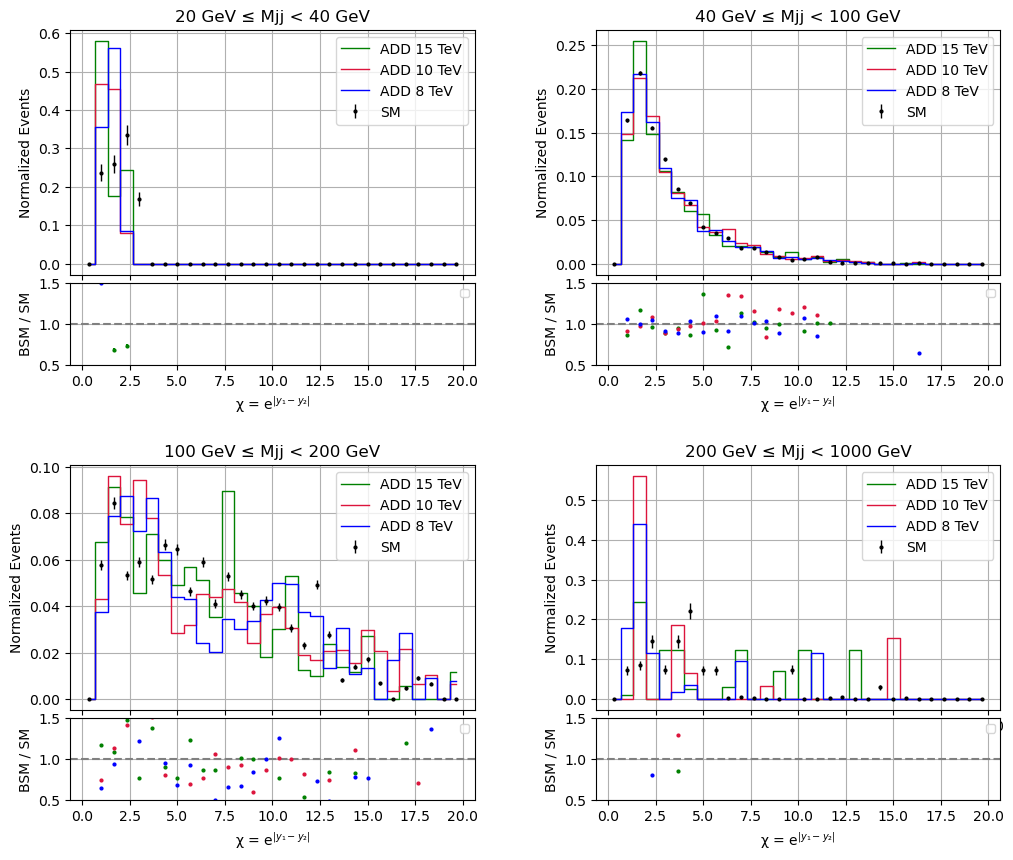

[qqprime 10TeV 20-40 GeV] χ²: 57.18, NDF: 5, Significance: 7.56σ
[qqprime 10TeV 20-40 GeV] χ²: 37.06, NDF: 5, Significance: 6.09σ
[qqprime 8TeV 20-40 GeV] χ²: 271.01, NDF: 5, Significance: 16.46σ
[qqprime 10TeV 40-100 GeV] χ²: 1884.86, NDF: 24, Significance: 43.41σ
[qqprime 10TeV 40-100 GeV] χ²: 682.28, NDF: 24, Significance: 26.12σ
[qqprime 8TeV 40-100 GeV] χ²: 1000.59, NDF: 24, Significance: 31.63σ
[qqprime 10TeV 100-200 GeV] χ²: 452.29, NDF: 27, Significance: 21.27σ
[qqprime 10TeV 100-200 GeV] χ²: 1692.80, NDF: 27, Significance: 41.14σ
[qqprime 8TeV 100-200 GeV] χ²: 1791.48, NDF: 27, Significance: 42.33σ
[qqprime 10TeV 200-1000 GeV] χ²: 2024.17, NDF: 11, Significance: 44.99σ
[qqprime 10TeV 200-1000 GeV] χ²: 757.63, NDF: 11, Significance: 27.53σ
[qqprime 8TeV 200-1000 GeV] χ²: 1192.63, NDF: 11, Significance: 34.53σ


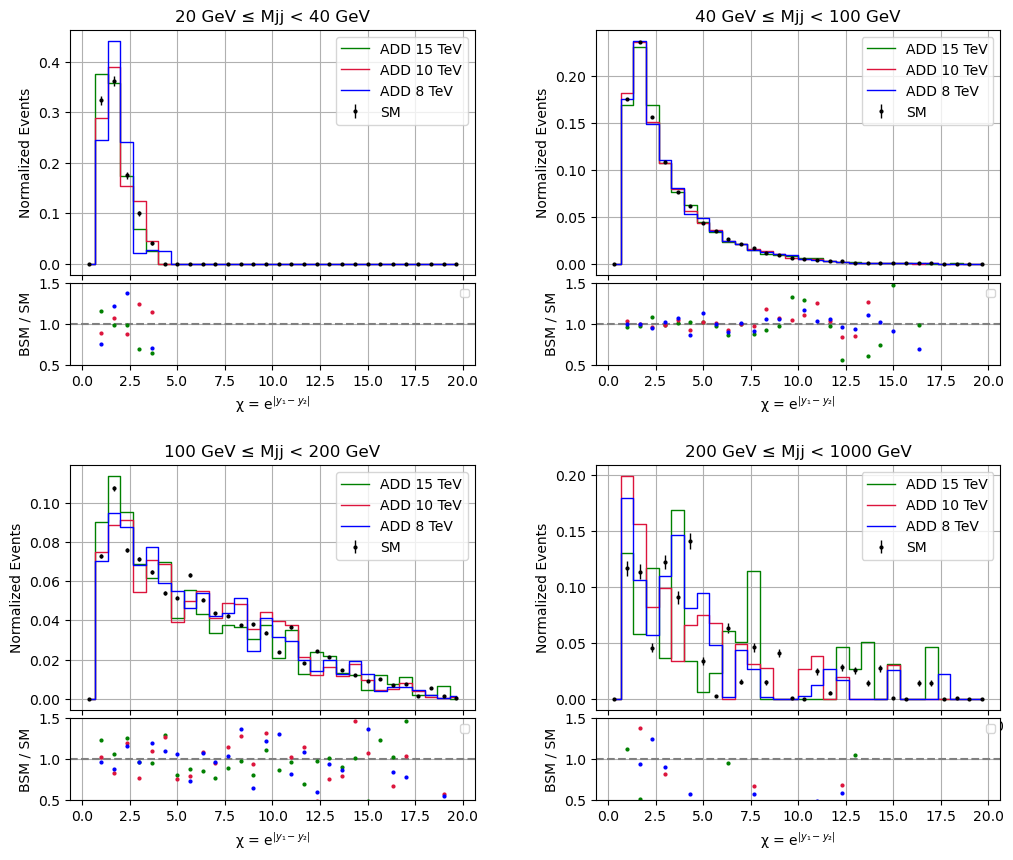

[qg 10TeV 20-40 GeV] χ²: 405.36, NDF: 6, Significance: 20.13σ
[qg 10TeV 20-40 GeV] χ²: 109.66, NDF: 6, Significance: 10.47σ
[qg 8TeV 20-40 GeV] χ²: 35.24, NDF: 6, Significance: 5.94σ
[qg 10TeV 40-100 GeV] χ²: 2355.13, NDF: 27, Significance: 48.53σ
[qg 10TeV 40-100 GeV] χ²: 1054.34, NDF: 27, Significance: 32.47σ
[qg 8TeV 40-100 GeV] χ²: 477.55, NDF: 27, Significance: 21.85σ
[qg 10TeV 100-200 GeV] χ²: 310.71, NDF: 29, Significance: 17.63σ
[qg 10TeV 100-200 GeV] χ²: 113.37, NDF: 29, Significance: 10.65σ
[qg 8TeV 100-200 GeV] χ²: 108.39, NDF: 29, Significance: 10.41σ
[qg 10TeV 200-1000 GeV] χ²: 3860.08, NDF: 25, Significance: 62.13σ
[qg 10TeV 200-1000 GeV] χ²: 941.52, NDF: 25, Significance: 30.68σ
[qg 8TeV 200-1000 GeV] χ²: 2415.90, NDF: 25, Significance: 49.15σ


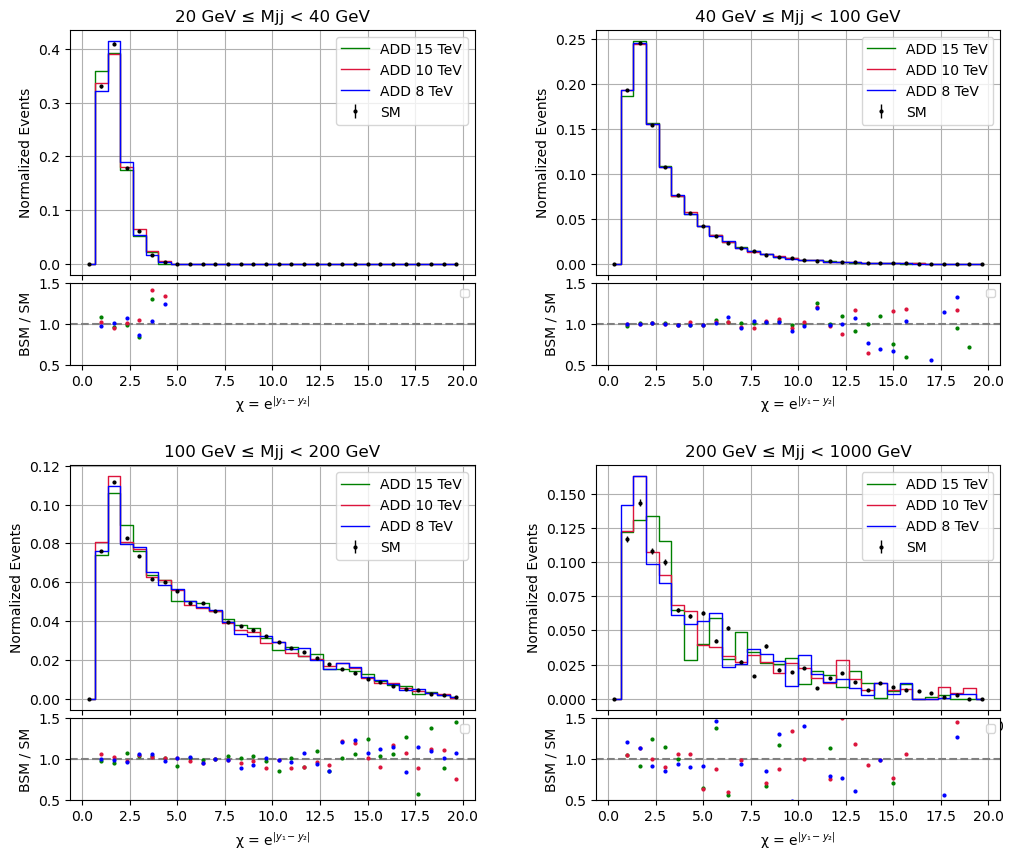

[gg 10TeV 20-40 GeV] χ²: 43.01, NDF: 6, Significance: 6.56σ
[gg 10TeV 20-40 GeV] χ²: 139.87, NDF: 6, Significance: 11.83σ
[gg 8TeV 20-40 GeV] χ²: 163.72, NDF: 6, Significance: 12.80σ
[gg 10TeV 40-100 GeV] χ²: 1507.48, NDF: 26, Significance: 38.83σ
[gg 10TeV 40-100 GeV] χ²: 163.67, NDF: 26, Significance: 12.79σ
[gg 8TeV 40-100 GeV] χ²: 532.98, NDF: 26, Significance: 23.09σ
[gg 10TeV 100-200 GeV] χ²: 725.87, NDF: 29, Significance: 26.94σ
[gg 10TeV 100-200 GeV] χ²: 413.02, NDF: 29, Significance: 20.32σ
[gg 8TeV 100-200 GeV] χ²: 198.17, NDF: 29, Significance: 14.08σ
[gg 10TeV 200-1000 GeV] χ²: 4443.77, NDF: 22, Significance: 66.66σ
[gg 10TeV 200-1000 GeV] χ²: 2980.66, NDF: 22, Significance: 54.60σ
[gg 8TeV 200-1000 GeV] χ²: 5791.81, NDF: 22, Significance: 76.10σ


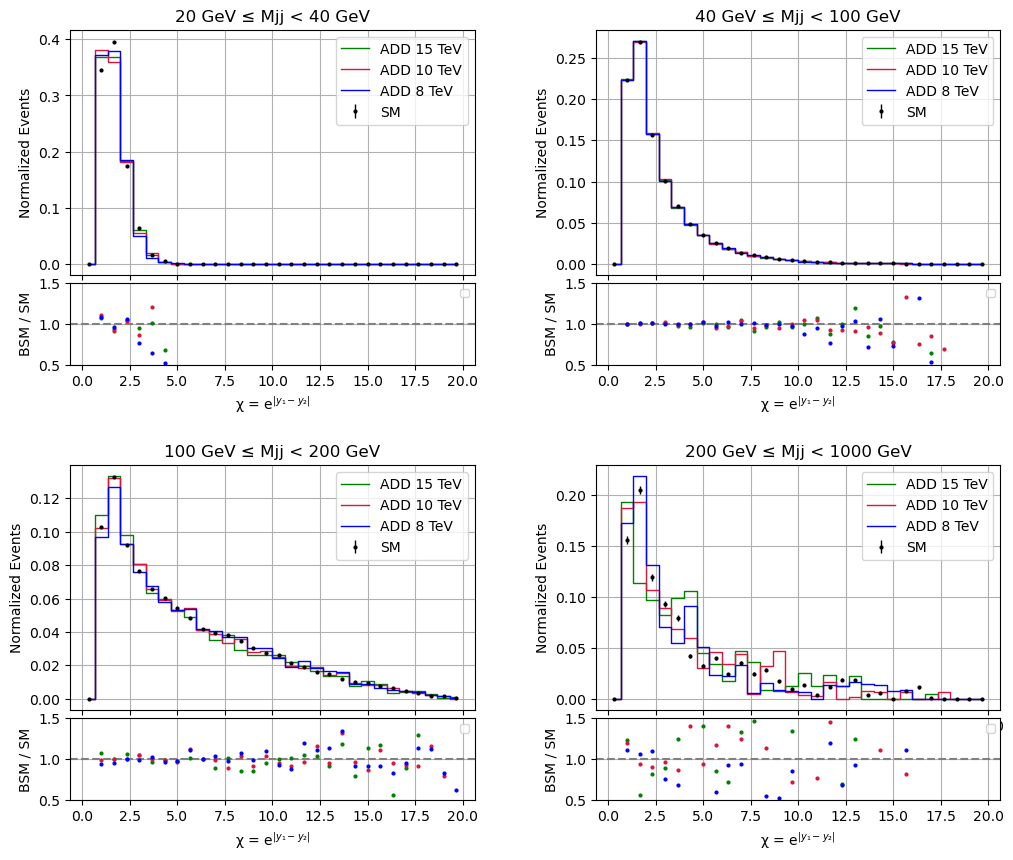

In [ ]:
def plot_chi_vs_mjj_for_subprocess_compare4(proc_label, df_sm_sub, df_add15_sub, df_add10_sub, df_add8_sub, scale_sm_proc, scale_add15_proc, scale_add10_proc, scale_add8_proc):

    fig = plt.figure(figsize=(12, 10))
    outer_grid = gridspec.GridSpec(2, 2, wspace=0.3, hspace=0.3)

    for i, (low, high) in enumerate(mjj_bins):
        row = i // 2
        col = i % 2

        # Subgrid with 2 rows (main + ratio), 1 column
        inner_grid = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_grid[row, col],
            height_ratios=[3, 1],
            hspace=0.05
        )
        
        ax_top = fig.add_subplot(inner_grid[0])
        ax_bot = fig.add_subplot(inner_grid[1], sharex=ax_top)

        # Filter events in this Mjj bin
        df_sm_bin = df_sm_sub.Filter(f"Mjj >= {low} && Mjj < {high}")
        df_add15_bin = df_add15_sub.Filter(f"Mjj >= {low} && Mjj < {high}")
        df_add10_bin = df_add10_sub.Filter(f"Mjj >= {low} && Mjj < {high}")
        df_add8_bin = df_add8_sub.Filter(f"Mjj >= {low} && Mjj < {high}")

        h_sm = df_sm_bin.Histo1D((f"h_chi_sm_{i}", "", 30, 0, 20), "chi")
        h_add15 = df_add15_bin.Histo1D((f"h_chi_add15_{i}", "", 30, 0, 20), "chi")
        h_add10 = df_add10_bin.Histo1D((f"h_chi_add10_{i}", "", 30, 0, 20), "chi")
        h_add8 = df_add8_bin.Histo1D((f"h_chi_add8_{i}", "", 30, 0, 20), "chi")

        edges, sm_vals, sm_vals_counts, sm_errors_counts, sm_errors_norm = root_hist_to_numpy(h_sm.GetPtr(), normalize=True)
        _, add15_vals, add15_vals_counts, _, _ = root_hist_to_numpy(h_add15.GetPtr(), normalize=True)
        _, add10_vals, add10_vals_counts, _, _ = root_hist_to_numpy(h_add10.GetPtr(), normalize=True)
        _, add8_vals, add8_vals_counts, _, _ = root_hist_to_numpy(h_add8.GetPtr(), normalize=True)
        centers = 0.5 * (edges[:-1] + edges[1:])

        #--------------------------------------------- Statistics ---------------------------------------------------
        
        # Here sm_vals_counts and add10_vals_counts represent *number of events in each chi bin in this Mjj range*
        # Multiply these by the scale factors to get expected events , normalize each dataset using scale facotr
        sm_counts_scaled = sm_vals_counts * scale_sm_proc
        add15_counts_scaled = add15_vals_counts * scale_add15_proc
        add10_counts_scaled = add10_vals_counts * scale_add10_proc
        add8_counts_scaled = add8_vals_counts * scale_add8_proc
        sm_errors_scaled = sm_errors_counts * scale_sm

        bin_key = (low, high)
        min_expected = min_expected_config.get(proc_label, {}).get(bin_key, 20)  # default to 20 if missing

        sm_counts_binned, add10_counts_binned, sm_errors_binned, edges_binned, bin_map = variable_binning_dual(sm_counts_scaled, add10_counts_scaled, sm_errors_scaled, edges, min_expected)
        add8_counts_binned = apply_variable_binning(add8_counts_scaled, bin_map)
        add15_counts_binned = apply_variable_binning(add15_counts_scaled, bin_map)

        syst_frac = 0.05
        _,_, sig_15 = compute_significance(sm_counts_binned, add15_counts_binned, sm_errors_binned, syst_frac, label=f"{proc_label} 10TeV {low}-{high} GeV")
        _,_, sig_10 = compute_significance(sm_counts_binned, add10_counts_binned, sm_errors_binned, syst_frac, label=f"{proc_label} 10TeV {low}-{high} GeV")
        _,_, sig_8 = compute_significance(sm_counts_binned, add8_counts_binned, sm_errors_binned, syst_frac, label=f"{proc_label} 8TeV {low}-{high} GeV")

        #------------------------------------------------------------------------------------------------------------

        h_sm_obj = h_sm.GetPtr()
        sm_errors = np.array([h_sm_obj.GetBinError(j + 1) for j in range(h_sm_obj.GetNbinsX())])
        if sm_vals.sum() > 0:
            sm_errors /= h_sm_obj.Integral()

        #Hide x-axis on top plot
        if i < len(mjj_bins) - 1:
            ax_top.tick_params(labelbottom=False)

        ax_top.errorbar(centers, sm_vals, yerr=sm_errors, fmt='o', markersize=2, color="black", linewidth=1, label = "SM")
        ax_top.step(centers, add15_vals, where='mid', color="green", linewidth=1, label = "ADD 15 TeV")        
        ax_top.step(centers, add10_vals, where='mid', color="crimson", linewidth=1, label = "ADD 10 TeV")
        ax_top.step(centers, add8_vals, where='mid', color="blue", linewidth=1, label = "ADD 8 TeV")        
        ax_top.set_ylabel("Normalized Events")
        ax_top.set_title(f"{low} GeV ≤ Mjj < {high} GeV")
        ax_top.legend()
        ax_top.grid(True)

        # box_text = (
        # r"Estimated Run 3 ($\mathcal{L}$ = 30 fb⁻¹)"
        # f"\nSig(15 TeV) = {sig_15:.2f}σ"
        # f"\nSig(10 TeV) = {sig_10:.2f}σ\n"
        # f"Sig(8 TeV) = {sig_8:.2f}σ")

        # ax_top.text(
        # 0.95, 0.95, box_text,
        # transform=ax_top.transAxes,
        # fontsize=8,
        # verticalalignment='top',
        # horizontalalignment='right',
        # bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white', alpha=0.9))        

        #15 TeV ration
        with np.errstate(divide='ignore', invalid='ignore'):
            ratio_15 = np.divide(add15_vals, sm_vals, out=np.zeros_like(add15_vals), where=sm_vals > 0)
            ratio15_err = np.divide(sm_errors, sm_vals, out=np.zeros_like(sm_errors), where=sm_vals > 0)
            ratio15_err = ratio_15 * ratio15_err

        # 10 TeV ratio
        with np.errstate(divide='ignore', invalid='ignore'):
            ratio_10 = np.divide(add10_vals, sm_vals, out=np.zeros_like(add10_vals), where=sm_vals > 0)
            ratio10_err = np.divide(sm_errors, sm_vals, out=np.zeros_like(sm_errors), where=sm_vals > 0)
            ratio10_err = ratio_10 * ratio10_err

        # 8 TeV ratio
        with np.errstate(divide='ignore', invalid='ignore'):
            ratio_8 = np.divide(add8_vals, sm_vals, out=np.zeros_like(add8_vals), where=sm_vals > 0)
            ratio8_err = np.divide(sm_errors, sm_vals, out=np.zeros_like(sm_errors), where=sm_vals > 0)
            ratio8_err = ratio_8 * ratio8_err

        ax_bot.errorbar(centers, ratio_15, yerr=sm_errors, fmt='o', markersize=2, color='green')
        ax_bot.errorbar(centers, ratio_10, yerr=sm_errors, fmt='o', markersize=2, color='crimson')
        ax_bot.errorbar(centers, ratio_8, yerr=sm_errors, fmt='o', markersize=2, color='blue')

        ax_bot.axhline(1.0, color='gray', linestyle='--')
        ax_bot.set_ylabel("BSM / SM")
        ax_bot.set_xlabel("χ = e$^{|y₁ - y₂|}$")
        ax_bot.set_ylim(0.5, 1.5)
        ax_bot.grid(True)
        ax_bot.legend(fontsize=8)

    fig.suptitle(f"χ Distribution in Mjj Bins ({proc_label} subprocess)", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    output_path = f"/eos/user/k/kmonagha/7_28_plots/chi_mjj_{proc_label}_15_10and8TeV.png"
    plt.savefig(output_path, dpi=300)
    plt.show()
    plt.close()
    print(f"Saved: {output_path}")

min_expected_config = {
    "qq":       { (20, 40): 10,  (40, 100): 10,  (100, 200): 50, (200, 1000): 0 },
    "qqprime":  { (20, 40): 10,  (40, 100): 100,  (100, 200): 175, (200, 1000): 200 },
    "qg":       { (20, 40): 10,  (40, 100): 200,  (100, 200): 50, (200, 1000): 200 },
    "gg":       { (20, 40): 10,  (40, 100): 150,  (100, 200): 50, (200, 1000): 200 },
}

process_types = ["qq", "qqprime", "qg", "gg"]
for proc in process_types:
    df_sm_proc = d_sm.Filter(f'process_type == "{proc}"')
    df_add15_proc = d_add_15.Filter(f'process_type == "{proc}"')
    df_add10_proc = d_add_10.Filter(f'process_type == "{proc}"')
    df_add8_proc = d_add_8.Filter(f'process_type == "{proc}"')

    # Compute number of events in the current subprocess
    num_sm_proc = df_sm_proc.Count().GetValue()
    num_add15_proc = df_add15_proc.Count().GetValue()
    num_add10_proc = df_add10_proc.Count().GetValue()
    num_add8_proc = df_add8_proc.Count().GetValue()

    # Apply scale to subprocess level by normalizing relative to the full sample scaling
    scale_sm_proc = scale_sm * (num_sm_proc / num_gen_sm)
    scale_add15_proc = scale_add15 * (num_add15_proc / num_gen_add15)
    scale_add10_proc = scale_add10 * (num_add10_proc / num_gen_add10)
    scale_add8_proc = scale_add8 * (num_add8_proc / num_gen_add8)

    plot_chi_vs_mjj_for_subprocess_compare4(proc, df_sm_proc, df_add15_proc, df_add10_proc, df_add8_proc, scale_sm_proc, scale_add15_proc, scale_add10_proc, scale_add8_proc)

Code for just the SM and 10TeV split processes

In [ ]:
def plot_chi_vs_mjj_for_subprocess_compare2(proc_label, df_sm_sub, df_add10_sub):

    fig = plt.figure(figsize=(12, 10))
    outer_grid = gridspec.GridSpec(2, 2, wspace=0.3, hspace=0.3)

    for i, (low, high) in enumerate(mjj_bins):
        row = i // 2
        col = i % 2

        # Subgrid with 2 rows (main + ratio), 1 column
        inner_grid = gridspec.GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=outer_grid[row, col],
            height_ratios=[3, 1],
            hspace=0.05
        )
        
        ax_top = fig.add_subplot(inner_grid[0])
        ax_bot = fig.add_subplot(inner_grid[1], sharex=ax_top)

        df_sm_bin = df_sm_sub.Filter(f"Mjj >= {low} && Mjj < {high}")
        df_add10_bin = df_add10_sub.Filter(f"Mjj >= {low} && Mjj < {high}")

        h_sm = df_sm_bin.Histo1D((f"h_chi_sm_{i}", "", 30, 0, 20), "chi")
        h_add10 = df_add10_bin.Histo1D((f"h_chi_bsm_{i}", "", 30, 0, 20), "chi")

        edges, sm_vals, sm_vals_counts, sm_errors_counts, sm_errors_norm = root_hist_to_numpy(h_sm.GetPtr(), normalize=True)
        _, add10_vals, add10_vals_counts, _, _ = root_hist_to_numpy(h_add10.GetPtr(), normalize=True)
        centers = 0.5 * (edges[:-1] + edges[1:])

        h_sm_obj = h_sm.GetPtr()
        sm_errors = np.array([h_sm_obj.GetBinError(j + 1) for j in range(h_sm_obj.GetNbinsX())])
        if sm_vals.sum() > 0:
            sm_errors /= h_sm_obj.Integral()


        #Hide x-axis on top plot
        if i < len(mjj_bins) - 1:
            ax_top.tick_params(labelbottom=False)

        ax_top.errorbar(centers, sm_vals, yerr=sm_errors, fmt='o', markersize=2, label="SM", color="black")
        ax_top.step(centers, add10_vals, where='mid', label="ADD λ = 10 TeV", color="crimson")
        ax_top.set_ylabel("Normalized Events")
        ax_top.set_title(f"{low} GeV ≤ Mjj < {high} GeV")
        ax_top.legend()
        ax_top.grid(True)

        with np.errstate(divide='ignore', invalid='ignore'):
            ratio = np.divide(add10_vals, sm_vals, out=np.zeros_like(add10_vals), where=sm_vals > 0)
            ratio_errors = np.divide(sm_errors, sm_vals, out=np.zeros_like(sm_errors), where=sm_vals > 0)
            ratio_errors = ratio * ratio_errors

        ax_bot.errorbar(centers, ratio, yerr=sm_errors, fmt='o', markersize=2.5, color='blue')
        ax_bot.axhline(1.0, color='gray', linestyle='--')
        ax_bot.set_ylabel("BSM / SM")
        ax_bot.set_xlabel("χ = e$^{|y₁ - y₂|}$")
        ax_bot.set_ylim(0.5, 1.5)
        ax_bot.grid(True)

        print(f"[DEBUG] SM total: {np.sum(sm_vals_counts):.1f}, ADD10 total: {np.sum(add10_vals_counts):.1f}")
        compute_asimov_significance_as_data(sm_vals, add10_vals, label=f"{low}-{high} GeV")

    fig.suptitle(f"χ Distribution in Mjj Bins ({proc_label} subprocess)", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    #output_path = f"/eos/user/k/kmonagha/7_17_plots/chi_mjj_{proc_label}_10TeV_2.png"
    #plt.savefig(output_path, dpi=300)
    plt.show()
    plt.close()
    #print(f"Saved: {output_path}")

process_types = ["qq", "qqprime", "qg", "gg"]
for proc in process_types:
    df_sm_proc = d_sm.Filter(f'process_type == "{proc}"')
    df_add10_proc = d_add_10.Filter(f'process_type == "{proc}"')
    plot_chi_vs_mjj_for_subprocess_compare2(proc, df_sm_proc, df_add10_proc)

Standard Model Chi in Mass Bins

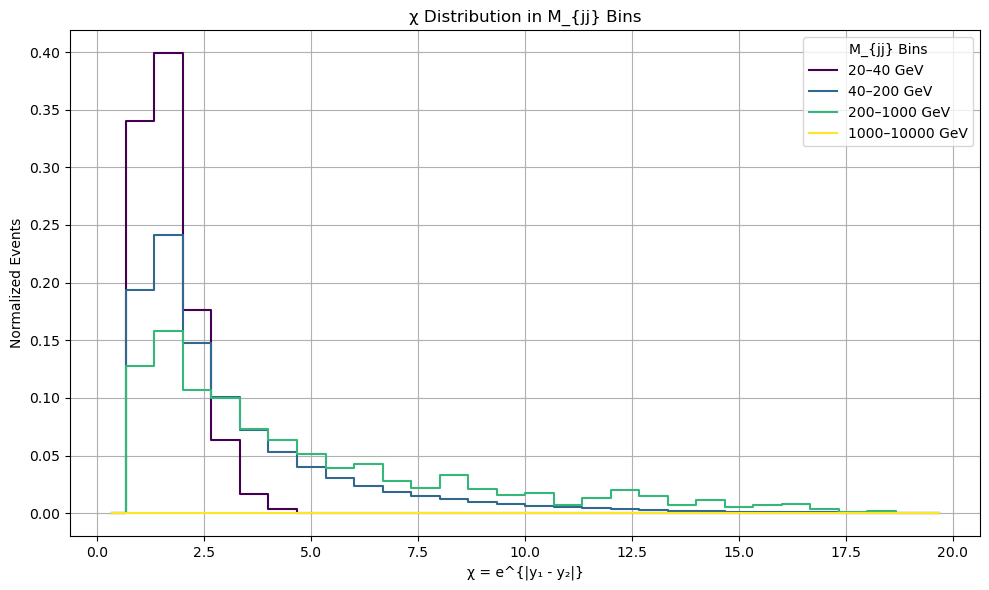

In [22]:
# Set up the plot
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(mjj_bins)))

# Step 2: Loop over Mjj bins
for i, (low, high) in enumerate(mjj_bins):
    #Filter dataframe
    df_bin = d_sm.Filter(f"Mjj >= {low} && Mjj < {high}")
    
    # Create chi histogram for this bin
    h_chi_bin = df_bin.Histo1D(
        (f"h_chi_{i}", f"χ distribution for {low} < Mjj < {high} GeV", 30, 0, 20),
        "chi"
    )
    
    # Step 4: Convert to NumPy
    edges, values = root_hist_to_numpy(h_chi_bin, normalize=True)
    centers = 0.5 * (edges[1:] + edges[:-1])
    
    # Step 5: Plot
    plt.step(centers, values, where='mid', label=f"{low}–{high} GeV", color=colors[i])

# Final plot setup
plt.xlabel("χ = e^{|y₁ - y₂|}")
plt.ylabel("Normalized Events")
plt.title("χ Distribution in M_{jj} Bins")
plt.legend(title="M_{jj} Bins")
plt.grid(True)
plt.tight_layout()
plt.show()